<div style="margin-bottom: 32px;">
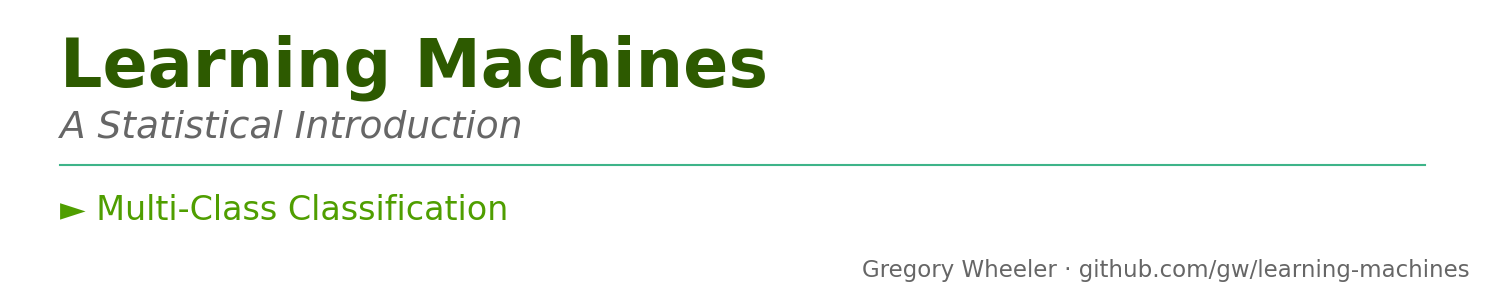
</div>


# Multi-Class Classification

Many real problems have more than two classes. This notebook explores two strategies for extending binary classification: One-vs-All (training K separate classifiers) and Softmax regression (a single model with K outputs). We visualize decision boundaries and compare how each method produces probability estimates.

**What computation adds**: Static diagrams show decision regions; here we watch both methods partition the feature space and examine how their probability predictions differ—particularly where OvA probabilities don't sum to one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

# For reproducibility
np.random.seed(42)

---
## 1. Multi-Class Classification Problem

Many real-world problems have more than two classes:
- Handwritten digit recognition: classes 0, 1, 2, ..., 9
- Image classification: cat, dog, bird, ...
- Document categorization: sports, politics, technology, ...

Let's create a synthetic dataset with 3 classes.

In [2]:
def generate_multiclass_data(n_per_class=50, seed=42):
    """Generate synthetic 3-class classification data."""
    np.random.seed(seed)
    
    # Class 0: centered at (1, 1)
    X0 = np.random.randn(n_per_class, 2) * 0.7 + np.array([1, 1])
    
    # Class 1: centered at (4, 1)
    X1 = np.random.randn(n_per_class, 2) * 0.7 + np.array([4, 1])
    
    # Class 2: centered at (2.5, 4)
    X2 = np.random.randn(n_per_class, 2) * 0.7 + np.array([2.5, 4])
    
    X = np.vstack([X0, X1, X2])
    y = np.array([0]*n_per_class + [1]*n_per_class + [2]*n_per_class)
    
    return X, y

X, y = generate_multiclass_data()
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print(f"Dataset: {n_samples} samples, {n_features} features, {n_classes} classes")

Dataset: 150 samples, 2 features, 3 classes


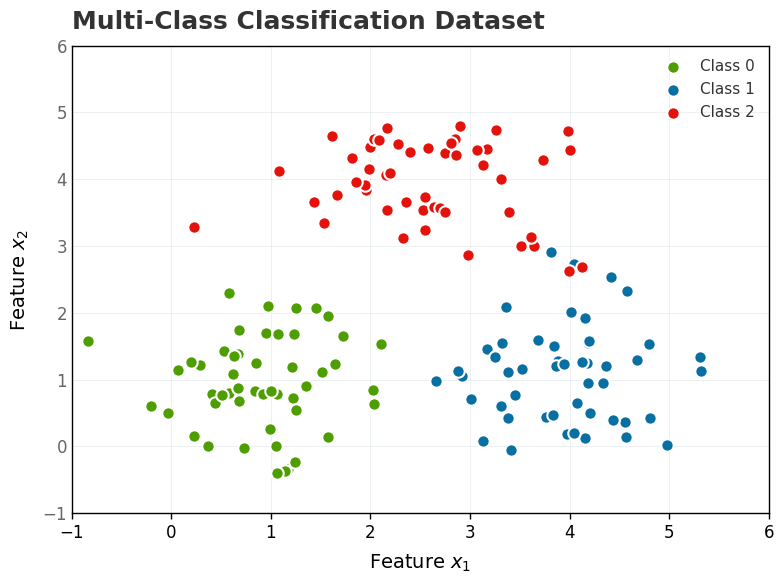

In [3]:
# Visualize the multi-class data
fig, ax = plt.subplots(figsize=(8, 6))

colors = [mt.GREEN, mt.BLUE, mt.RED]
labels = ['Class 0', 'Class 1', 'Class 2']

for c in range(n_classes):
    mask = y == c
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[c], s=80,
               label=labels[c], edgecolors='white', linewidths=1.5, zorder=3)

ax.set_xlabel('Feature $x_1$')
ax.set_ylabel('Feature $x_2$')
ax.set_title('Multi-Class Classification Dataset', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)

# Custom styling for scatter plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2. One-vs-All (One-vs-Rest) Classification

The **One-vs-All (OvA)** strategy trains $K$ binary classifiers, one for each class:

- Classifier 1: Class 0 vs. (Class 1 + Class 2)
- Classifier 2: Class 1 vs. (Class 0 + Class 2)
- Classifier 3: Class 2 vs. (Class 0 + Class 1)

To predict, we run all $K$ classifiers and pick the class with the highest confidence.

In [4]:
# First, let's define our binary logistic regression components

def sigmoid(z):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def compute_cost(X, y, theta):
    """Log-loss cost function."""
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    cost = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def compute_gradient(X, y, theta):
    """Gradient of log-loss."""
    m = len(y)
    h = sigmoid(X @ theta)
    gradient = (1/m) * X.T @ (h - y)
    return gradient

def train_binary_classifier(X, y, learning_rate=1.0, n_iterations=1000):
    """Train a binary logistic regression classifier."""
    theta = np.zeros(X.shape[1])
    
    for _ in range(n_iterations):
        gradient = compute_gradient(X, y, theta)
        theta = theta - learning_rate * gradient
    
    return theta

In [5]:
def train_one_vs_all(X, y, n_classes, learning_rate=1.0, n_iterations=1000):
    """
    Train One-vs-All classifiers.
    
    Returns
    -------
    all_theta : ndarray of shape (n_classes, n_features + 1)
        Parameters for each binary classifier
    """
    m, n = X.shape
    
    # Add intercept
    X_design = np.column_stack([np.ones(m), X])
    
    # Train one classifier per class
    all_theta = np.zeros((n_classes, n + 1))
    
    for c in range(n_classes):
        # Binary labels: 1 for current class, 0 for all others
        y_binary = (y == c).astype(float)
        
        # Train classifier
        theta_c = train_binary_classifier(X_design, y_binary, 
                                          learning_rate, n_iterations)
        all_theta[c] = theta_c
        
        # Report
        accuracy = np.mean((sigmoid(X_design @ theta_c) >= 0.5) == y_binary)
        print(f"Classifier {c} (Class {c} vs Rest): accuracy = {accuracy:.1%}")
    
    return all_theta

In [6]:
# Train OvA classifiers
all_theta = train_one_vs_all(X, y, n_classes, learning_rate=1.0, n_iterations=2000)

Classifier 0 (Class 0 vs Rest): accuracy = 98.7%
Classifier 1 (Class 1 vs Rest): accuracy = 98.0%
Classifier 2 (Class 2 vs Rest): accuracy = 97.3%


In [7]:
def predict_one_vs_all(X, all_theta):
    """
    Predict class using One-vs-All classifiers.
    
    Returns the class with the highest probability from any classifier.
    """
    m = X.shape[0]
    X_design = np.column_stack([np.ones(m), X])
    
    # Compute probability for each class
    probabilities = sigmoid(X_design @ all_theta.T)  # shape: (m, n_classes)
    
    # Predict class with highest probability
    predictions = np.argmax(probabilities, axis=1)
    
    return predictions, probabilities

In [8]:
# Evaluate OvA classifier
y_pred, probs = predict_one_vs_all(X, all_theta)
accuracy = np.mean(y_pred == y)
print(f"\nOverall OvA accuracy: {accuracy:.1%}")


Overall OvA accuracy: 98.0%


---
## 3. Visualizing OvA Decision Boundaries

Each binary classifier defines a decision boundary. The final multi-class boundary is the intersection of these regions.

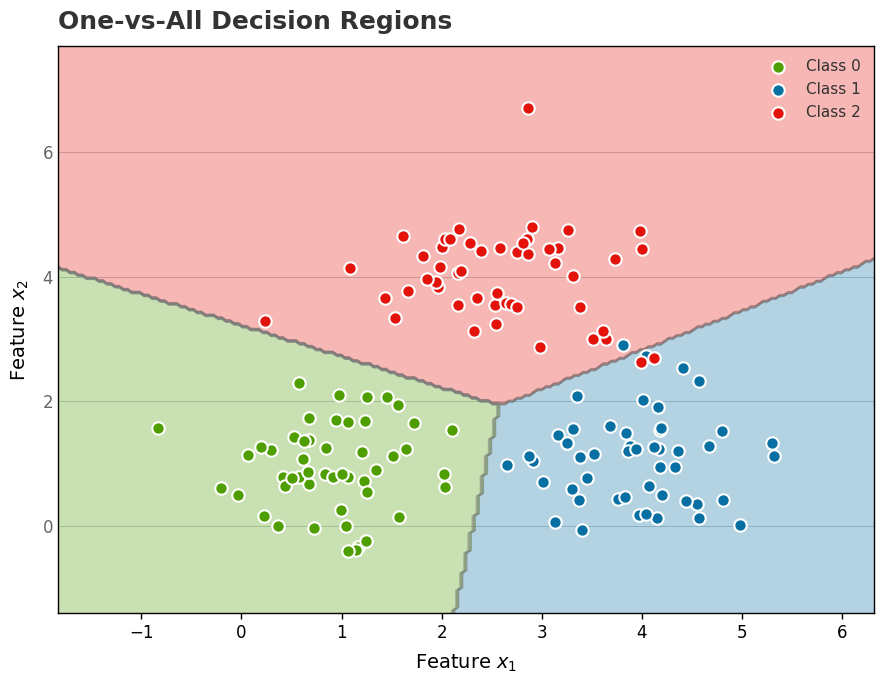

In [9]:
def plot_decision_regions(X, y, all_theta, title="Decision Regions"):
    """Plot decision regions for multi-class classifier."""
    fig, ax = plt.subplots(figsize=(9, 7))
    
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict on mesh
    X_mesh = np.column_stack([xx.ravel(), yy.ravel()])
    Z, _ = predict_one_vs_all(X_mesh, all_theta)
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions
    colors_light = [mt.GREEN, mt.BLUE, mt.RED]
    cmap_light = ListedColormap([c + '30' for c in colors_light])  # Add alpha
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(colors_light))
    ax.contour(xx, yy, Z, colors='gray', linewidths=1, alpha=0.5)
    
    # Plot data points
    colors = [mt.GREEN, mt.BLUE, mt.RED]
    labels = ['Class 0', 'Class 1', 'Class 2']
    for c in range(n_classes):
        mask = y == c
        ax.scatter(X[mask, 0], X[mask, 1], c=colors[c], s=80,
                   label=labels[c], edgecolors='white', linewidths=1.5, zorder=3)
    
    ax.set_xlabel('Feature $x_1$')
    ax.set_ylabel('Feature $x_2$')
    ax.set_title(title, fontweight='bold', loc='left')
    ax.legend(loc='upper right')
    
    # Styling
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position('left')
    
    plt.tight_layout()
    return fig, ax

plot_decision_regions(X, y, all_theta, "One-vs-All Decision Regions")
plt.show()

---
## 4. Individual Binary Classifiers

Let's visualize what each individual OvA classifier sees.

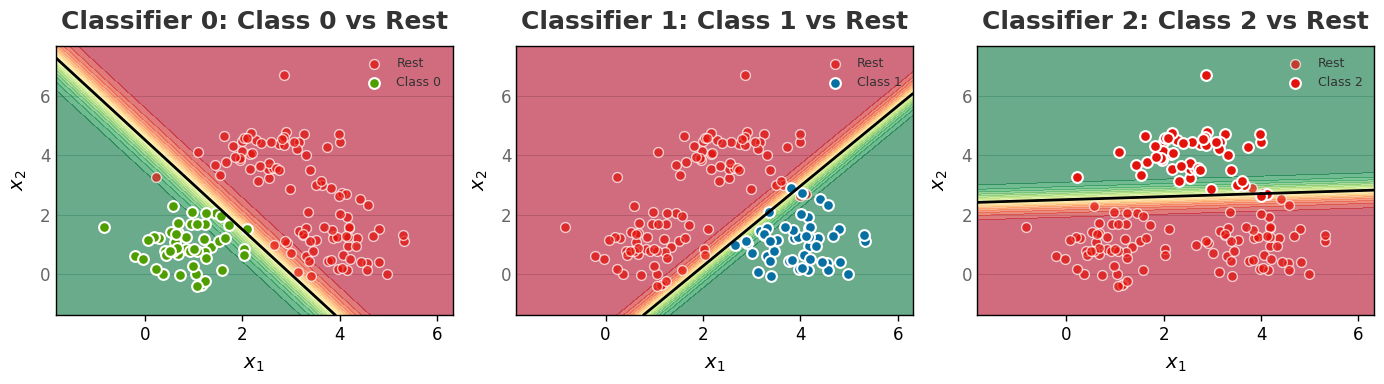

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

colors = [mt.GREEN, mt.BLUE, mt.RED]

for c, ax in enumerate(axes):
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Compute probability for this classifier
    X_mesh = np.column_stack([np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()])
    Z = sigmoid(X_mesh @ all_theta[c]).reshape(xx.shape)
    
    # Plot probability surface
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    y_binary = (y == c).astype(int)
    ax.scatter(X[y_binary == 0, 0], X[y_binary == 0, 1], c=mt.RED, s=50,
               label='Rest', edgecolors='white', linewidths=1, alpha=0.7)
    ax.scatter(X[y_binary == 1, 0], X[y_binary == 1, 1], c=colors[c], s=60,
               label=f'Class {c}', edgecolors='white', linewidths=1.5)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'Classifier {c}: Class {c} vs Rest', fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    
    # Styling
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.yaxis.tick_left()

plt.tight_layout()
plt.show()

---
## 5. Softmax Regression (Multinomial Logistic Regression)

An alternative to OvA is **softmax regression**, which directly models the probability of each class:

$$P(y = k \mid x) = \frac{e^{\theta_k^T x}}{\sum_{j=1}^{K} e^{\theta_j^T x}}$$

This is called the **softmax function**. It ensures:
- All probabilities are positive
- Probabilities sum to 1

In [11]:
def softmax(z):
    """
    Compute softmax probabilities.
    
    Parameters
    ----------
    z : ndarray of shape (m, K)
        Raw scores for each class
    
    Returns
    -------
    ndarray of shape (m, K)
        Probability for each class (rows sum to 1)
    """
    # Subtract max for numerical stability
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [12]:
# Demonstrate softmax
z_demo = np.array([[2.0, 1.0, 0.1],
                   [1.0, 2.0, 0.1],
                   [0.1, 0.1, 2.0]])

probs_demo = softmax(z_demo)

print("Raw scores (z):")
print(z_demo)
print("\nSoftmax probabilities:")
print(np.round(probs_demo, 3))
print("\nRow sums:", probs_demo.sum(axis=1))

Raw scores (z):
[[2.  1.  0.1]
 [1.  2.  0.1]
 [0.1 0.1 2. ]]

Softmax probabilities:
[[0.659 0.242 0.099]
 [0.242 0.659 0.099]
 [0.115 0.115 0.77 ]]

Row sums: [1. 1. 1.]


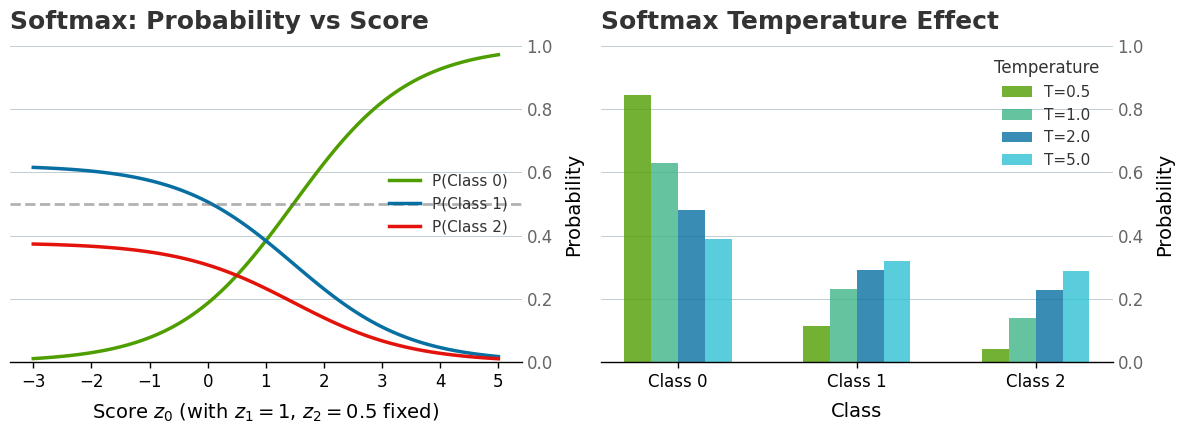

In [13]:
# Visualize softmax behavior
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: Softmax as function of one score
ax = axes[0]
z1_range = np.linspace(-3, 5, 100)
z_fixed = np.column_stack([z1_range, np.ones(100) * 1.0, np.ones(100) * 0.5])
probs = softmax(z_fixed)

ax.plot(z1_range, probs[:, 0], c=mt.GREEN, linewidth=2.5, label='P(Class 0)')
ax.plot(z1_range, probs[:, 1], c=mt.BLUE, linewidth=2.5, label='P(Class 1)')
ax.plot(z1_range, probs[:, 2], c=mt.RED, linewidth=2.5, label='P(Class 2)')

ax.axhline(y=0.5, color=mt.GRAY, linestyle='--', alpha=0.5)
ax.set_xlabel(r'Score $z_0$ (with $z_1=1$, $z_2=0.5$ fixed)')
ax.set_ylabel('Probability')
ax.set_title('Softmax: Probability vs Score', fontweight='bold', loc='left')
ax.legend(loc='right')
ax.set_ylim(0, 1)
mt.apply_economist_style(ax)

# Right: Softmax "sharpness" with temperature
ax = axes[1]
z_base = np.array([[2.0, 1.0, 0.5]])

temps = [0.5, 1.0, 2.0, 5.0]
width = 0.15
x_pos = np.arange(3)

for i, T in enumerate(temps):
    probs_t = softmax(z_base / T)[0]
    offset = (i - 1.5) * width
    bars = ax.bar(x_pos + offset, probs_t, width, label=f'T={T}', alpha=0.8)

ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_title('Softmax Temperature Effect', fontweight='bold', loc='left')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
ax.legend(title='Temperature')
ax.set_ylim(0, 1)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 6. Training Softmax Regression

The cost function for softmax regression is the **cross-entropy loss**:

$$J(\Theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \mathbb{1}\{y^{(i)} = k\} \log P(y^{(i)} = k \mid x^{(i)})$$

where $\mathbb{1}\{\cdot\}$ is the indicator function.

In [14]:
def one_hot_encode(y, n_classes):
    """Convert class labels to one-hot encoding."""
    m = len(y)
    Y = np.zeros((m, n_classes))
    Y[np.arange(m), y.astype(int)] = 1
    return Y

def softmax_cost(X, Y, Theta):
    """
    Compute cross-entropy cost for softmax regression.
    
    Parameters
    ----------
    X : ndarray of shape (m, n)
        Feature matrix with intercept
    Y : ndarray of shape (m, K)
        One-hot encoded labels
    Theta : ndarray of shape (n, K)
        Parameters for all classes
    """
    m = X.shape[0]
    scores = X @ Theta  # (m, K)
    probs = softmax(scores)  # (m, K)
    
    # Cross-entropy loss
    epsilon = 1e-15
    probs = np.clip(probs, epsilon, 1 - epsilon)
    cost = -np.sum(Y * np.log(probs)) / m
    
    return cost

def softmax_gradient(X, Y, Theta):
    """
    Compute gradient of cross-entropy cost.
    
    Returns
    -------
    ndarray of shape (n, K)
        Gradient with respect to Theta
    """
    m = X.shape[0]
    scores = X @ Theta
    probs = softmax(scores)
    
    # Gradient: (1/m) * X^T @ (probs - Y)
    gradient = (1/m) * X.T @ (probs - Y)
    
    return gradient

In [15]:
def train_softmax(X, y, n_classes, learning_rate=1.0, n_iterations=1000):
    """
    Train softmax regression using gradient descent.
    
    Returns
    -------
    Theta : ndarray of shape (n_features + 1, n_classes)
    cost_history : list of costs during training
    """
    m, n = X.shape
    
    # Add intercept
    X_design = np.column_stack([np.ones(m), X])
    
    # One-hot encode labels
    Y = one_hot_encode(y, n_classes)
    
    # Initialize parameters
    Theta = np.zeros((n + 1, n_classes))
    
    cost_history = []
    
    for i in range(n_iterations):
        cost = softmax_cost(X_design, Y, Theta)
        cost_history.append(cost)
        
        gradient = softmax_gradient(X_design, Y, Theta)
        Theta = Theta - learning_rate * gradient
        
        if i % 200 == 0:
            print(f"Iteration {i}: cost = {cost:.4f}")
    
    return Theta, cost_history

In [16]:
# Train softmax regression
Theta_softmax, cost_history = train_softmax(X, y, n_classes, 
                                            learning_rate=1.0, 
                                            n_iterations=1000)

print(f"\nFinal cost: {cost_history[-1]:.4f}")

Iteration 0: cost = 1.0986
Iteration 200: cost = 0.0711
Iteration 400: cost = 0.0577
Iteration 600: cost = 0.0526
Iteration 800: cost = 0.0499

Final cost: 0.0481


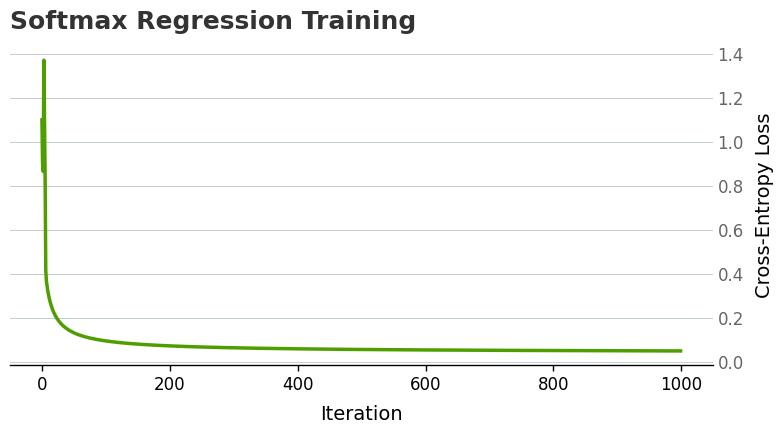

In [17]:
# Plot convergence
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(cost_history, c=mt.GREEN, linewidth=2.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Softmax Regression Training', fontweight='bold', loc='left')

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

In [18]:
def predict_softmax(X, Theta):
    """Predict class using softmax regression."""
    m = X.shape[0]
    X_design = np.column_stack([np.ones(m), X])
    
    scores = X_design @ Theta
    probs = softmax(scores)
    predictions = np.argmax(probs, axis=1)
    
    return predictions, probs

# Evaluate
y_pred_sm, probs_sm = predict_softmax(X, Theta_softmax)
accuracy_sm = np.mean(y_pred_sm == y)
print(f"Softmax accuracy: {accuracy_sm:.1%}")

Softmax accuracy: 98.0%


---
## 7. Comparing OvA and Softmax Decision Boundaries

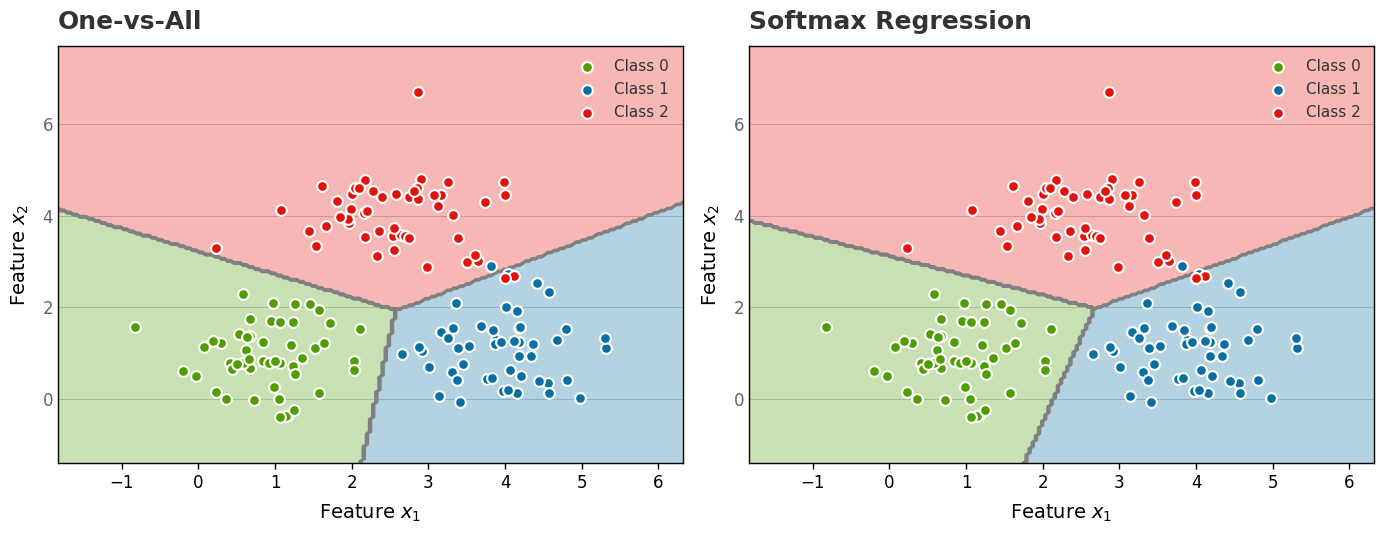

OvA accuracy: 98.0%
Softmax accuracy: 98.0%


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Create mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
X_mesh = np.column_stack([xx.ravel(), yy.ravel()])

colors = [mt.GREEN, mt.BLUE, mt.RED]
labels = ['Class 0', 'Class 1', 'Class 2']

# Left: OvA
ax = axes[0]
Z_ova, _ = predict_one_vs_all(X_mesh, all_theta)
Z_ova = Z_ova.reshape(xx.shape)

ax.contourf(xx, yy, Z_ova, alpha=0.3, cmap=ListedColormap(colors))
ax.contour(xx, yy, Z_ova, colors='gray', linewidths=1.5)

for c in range(n_classes):
    mask = y == c
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[c], s=60,
               label=labels[c], edgecolors='white', linewidths=1.5, zorder=3)

ax.set_xlabel('Feature $x_1$')
ax.set_ylabel('Feature $x_2$')
ax.set_title('One-vs-All', fontweight='bold', loc='left')
ax.legend(loc='upper right')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')

# Right: Softmax
ax = axes[1]
Z_sm, _ = predict_softmax(X_mesh, Theta_softmax)
Z_sm = Z_sm.reshape(xx.shape)

ax.contourf(xx, yy, Z_sm, alpha=0.3, cmap=ListedColormap(colors))
ax.contour(xx, yy, Z_sm, colors='gray', linewidths=1.5)

for c in range(n_classes):
    mask = y == c
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[c], s=60,
               label=labels[c], edgecolors='white', linewidths=1.5, zorder=3)

ax.set_xlabel('Feature $x_1$')
ax.set_ylabel('Feature $x_2$')
ax.set_title('Softmax Regression', fontweight='bold', loc='left')
ax.legend(loc='upper right')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')

plt.tight_layout()
plt.show()

print(f"OvA accuracy: {accuracy:.1%}")
print(f"Softmax accuracy: {accuracy_sm:.1%}")

---
## 8. Probability Predictions

Both methods output probabilities, but they're computed differently.

In [20]:
# Compare probability predictions for a few points
test_points = np.array([
    [1.0, 1.0],   # Near Class 0 center
    [4.0, 1.0],   # Near Class 1 center
    [2.5, 4.0],   # Near Class 2 center
    [2.5, 2.0],   # Between classes
])

print("Probability comparisons:")
print("=" * 70)

for i, point in enumerate(test_points):
    _, probs_ova = predict_one_vs_all(point.reshape(1, -1), all_theta)
    _, probs_sm = predict_softmax(point.reshape(1, -1), Theta_softmax)
    
    print(f"\nPoint ({point[0]:.1f}, {point[1]:.1f}):")
    print(f"  OvA:     P(C0)={probs_ova[0,0]:.3f}, P(C1)={probs_ova[0,1]:.3f}, P(C2)={probs_ova[0,2]:.3f}")
    print(f"  Softmax: P(C0)={probs_sm[0,0]:.3f}, P(C1)={probs_sm[0,1]:.3f}, P(C2)={probs_sm[0,2]:.3f}")
    
    # Note: OvA probabilities don't sum to 1
    print(f"  OvA sum: {probs_ova.sum():.3f}, Softmax sum: {probs_sm.sum():.3f}")

Probability comparisons:

Point (1.0, 1.0):
  OvA:     P(C0)=0.996, P(C1)=0.000, P(C2)=0.000
  Softmax: P(C0)=0.999, P(C1)=0.001, P(C2)=0.001
  OvA sum: 0.997, Softmax sum: 1.000

Point (4.0, 1.0):
  OvA:     P(C0)=0.001, P(C1)=1.000, P(C2)=0.000
  Softmax: P(C0)=0.000, P(C1)=1.000, P(C2)=0.000
  OvA sum: 1.001, Softmax sum: 1.000

Point (2.5, 4.0):
  OvA:     P(C0)=0.000, P(C1)=0.000, P(C2)=0.999
  Softmax: P(C0)=0.000, P(C1)=0.000, P(C2)=1.000
  OvA sum: 0.999, Softmax sum: 1.000

Point (2.5, 2.0):
  OvA:     P(C0)=0.032, P(C1)=0.015, P(C2)=0.040
  Softmax: P(C0)=0.464, P(C1)=0.176, P(C2)=0.360
  OvA sum: 0.087, Softmax sum: 1.000


**Key observation:** OvA probabilities don't sum to 1 (each classifier is independent), while softmax probabilities always sum to 1 by construction.

---
## Summary

**Multi-class classification approaches:**

| Approach | Description | Pros | Cons |
|----------|-------------|------|------|
| **One-vs-All** | Train $K$ binary classifiers | Simple, parallelizable | Probabilities don't sum to 1 |
| **Softmax** | Single model with $K$ outputs | Proper probabilities | More parameters |

**Key formulas:**
- Softmax: $P(y=k \mid x) = \frac{e^{\theta_k^T x}}{\sum_j e^{\theta_j^T x}}$
- Cross-entropy loss: $J = -\frac{1}{m} \sum_i \sum_k y_k^{(i)} \log P(y=k \mid x^{(i)})$

**Next steps** (covered in the book):
- Model evaluation metrics for multi-class
- Confusion matrices
- Regularization for logistic/softmax regression